In [1]:
from tensorflow import keras
import tensorflow as tf

# 13. 텐서플로에서 데이터 적재 및 전처리 수행
- 메모리 용량에 맞지 않는 아주 큰 규모의 데이터로 딥러닝을 해야하는 경우가 있음
- 텐스플로는 데이터 API로 이 문제를 쉽게 처리할 수 있음
- 데이터셋 객체를 만들고, 데이터를 읽을 위치와 변환 방법을 저장하면 됨
    - 그러면, 텐서플로가 알아서 멀티스레딩, 큐, 배치, 프리페치와 같은 상세 사항을 모두 대신 잘 처리하며, tf.keras와도 잘 동작함

- 기본적인 기능으로 데이터 API는 csv와 같은 텍스트파일, 고정 길이 레코드의 바이너리 파일, 텐서플로의 TFRecord포맷을 사용하는 바이너리 파일에서 데이터를 읽을 수 있음
    - TFRecord는 길이가 다른 레코드를 지원함ㄴ
- 또한 데이터 API는 SQL DB리딩을 지원하며, 빅쿼리와 같은 다양한 데이터 소스에서 데이터를 읽어올 수 있는 오픈 소스도 있음
- 그런데 읽어오는 것도 읽어오는 것인데, 정규화같은 데이터 전처리가 필요하며, 데이터가 단순히 수치형 필드로만 구성되는 것도 아님
    - 이런 특성들은 원핫인코딩, Bag of words 인코딩, 임베딩 등을 활용하여 인코딩 되어야함
- 이런 모든 전처리 과정을 처리하기 위해 사용자 정의 전처리 층을 마드는 방법 + 케라스에서 제공하는 표준 전처리 층을 이용하는 방법이 있음
- tf.Transform
    - 데이터 연산 속도를 높이기 위해 훈련 전에 전체 훈련 세트에 대해 실행하는 전처리함수 작성 가능
    - 그 다음 텐서플로 함수로 변환하고 상용 환경에 배포된 다음, 훈련된 모델과 협업하여 새로운 샘플에 대해 동적으로 처리 가능
    - 일종의 파이프라인으로써의 역할을 수행함
- TFDS
    - 각종 데이터셋을 다운로드할 수 있는 리한 함수를 제공함

# 13.1. 데이터 API
- 데이터 API의 중심에는 **데이터셋**개념이 있음
    - 연속된 데이터 샘플을 나타냄
    - 일반적으로 디스크에서 데이터를 점진적으로 읽는 데이터셋을 사용
        - *지금은 간단히 tf.data.Dataset.from_tensor_slices()로 메모리에서 데이터셋을 생성해보겠음*

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

- **from_tensor_slices()** 함수는 첫 번쨰 ㅈ차원을 따라 X의 각 원소가 아이템으로 표현되는 tf.data.Dataset을 만듦
    - 즉 위 예시에서는 0 ~ 9까지 1총 10개의 아이템을 갖게 됨
    - tf.data.Dataset.range(10)과 동일함

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### 13.1.1. 연쇄 변환
- 데이터셋이 준비되면 변환 메서드로 여러 종류의 변환을 수행할 수 있음
- **각 메서드는 새로운 데이터셋을 반환함(inplace = True인 상태)
- 따라서 다음과 같이 변환 메서드를 연결하여 연쇄변환을 수행할 수 있음

In [4]:
dataset = dataset.repeat(3).batch(7)

for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


- 위에서 수행한 연쇄적 변환은 다음과 같으 그림으로 표현할 수 있음
- 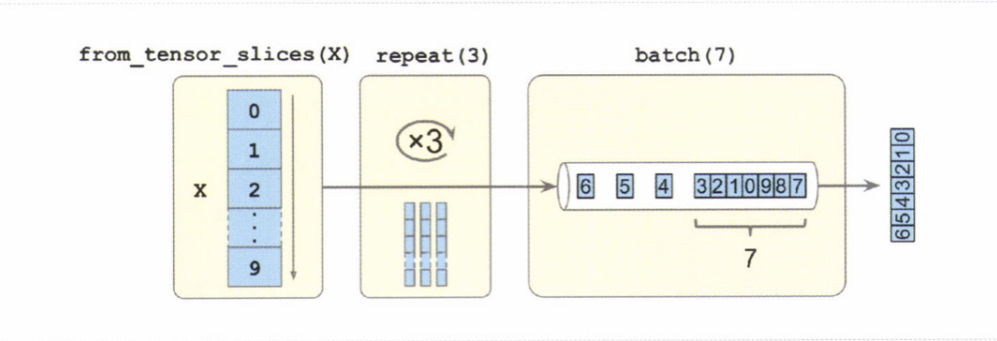
    - Hands On ML(13-1)
- 먼저 원본 데이터셋에서 repeat메서드를 호출 -> 세 차례 반복
    - 그 다음 그걸 받아서 바로 배치 처리 -> 새로운 데이터셋 생성
    - 만약 drop_reminder = True로 호출하면 길이가 모자란 마지막 배치를 버리고 모든 배치를 동일한 크기로 맞춤

- map메서드로 아이템을 변환할 수도 있음
    - 예를 들어 다음 코드는 모든 아이템에 2를 곱하여 새로운 데이터셋을 생성함

In [5]:
dataset = dataset.map(lambda x : x * 2)

for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


- 이 함수는 데이터에 어떤 전처리 작업을 수행하든 적용할 수 있음
- 가끔 이미지 크기 변환이나 회전 같은 복잡한 계산을 포함할 때는 **num_parallel_calls**매개변수를 지정하여 스레드를 나누어 속도를 높일 수 있음

- map메서드는 각 아이템에 변환을 적용
    - apply메서드는 데이터셋 전체에 변환을 적용
- 예를 들어 다음 코드는 데이터셋에 unbatch()함수를 적용함

In [6]:
dataset = dataset.apply(tf.data.experimental.unbatch())

for item in dataset:
    print(item)

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=

- filter함수로 필터링도 가능

In [7]:
dataset = dataset.filter(lambda x : x < 10)
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


- 몇 개의 아이템만 보고자할 경우 take()메서드 활용

In [8]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### 13.1.2. 데이터 셔플링
- 경사하강법은 훈련 세트 내 샘플이 독립적이고 동일한 분포일 때 최고 성능을 발휘함
- 이렇게 하는 간단한 방식이 shuffle 메서드를 이용하는 것
- 이 메서드는 원본 데이터셋의 처음 아이템을 buffer_size개수만큼 추출하여 버퍼에 채우고, 새로운 아이템이 요청될 경우 이 버퍼에서 랜덤하게 하나를 꺼내 반환함
    - 그리고 원본 데이터셋에서 새로운 아이템을 추출하여 비워진 버퍼를 채움
    - 이렇게 반복하여, 랜덤하게 아이템을 게소 반환
- 이 메서드를 이용하려면 버퍼 크기를 지정해야하는데, 이 때 그 크기를 충분히 크게 하는 것이 중요함
    - 그렇지 않으면 셔플링의 효과가 감소
    - 다만, 메모리 크기를 넘기면 안됨
    - + 굳이, 버퍼 크기가 데이터셋보다는 크게 할 필요 없음
- 랜덤 시드를 부여하여 셔플링 순서를 동일하게 만들 수 있음
    - 예를 들어 다음 코드는 0~9까지 세 번 반복된 데이터셋을 만들고 버퍼 크기 5와 랜덤시드 42를 사용하여 셔플링하고 배치 크기 7로 나누어 출력

In [13]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size = 5, seed = 42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


- 지금은 데이터 크기가 30인데, 버퍼 사이즈를 5로 잡았음

- 그런데 메모리 용량보다 큰 대규모 데이터셋은 버퍼가 데이터셋에 비해 작기 때문에 간단한 셔플링 버퍼 방식으로는 충분하지 않을 수 있음
- 이를 해결하는 방법은 원본 데이터 자체를 섞어버리는 것
    - *사실 이렇게 하면 셔플링 효과가 크게 향상됨*
- 그리고 원본 데이터가 셔플링되어있어도 일반적으로 에포크마다 한 번 더 섞게 됨
    - 그렇지 않으면 에포크마다 순서가 동일하게 되어 편향이 추가되어 가짜 패턴이 발견될 수도 있음
- 샘플을 더 섞기 위해서 많이 사용하는 방식은 원본 데이터를 여러 파일로 나눈 다음 훈련하는 동안 무작위로 읽는 것
    - 그런데 이렇게해도 동일 파일 내 샘플은 여전히 같이 처리되게 됨
    - 이를 피하기 위해서 파일 여러개를 무작위로 선택하고 파일에서 동시에 읽은 레코드를 돌아가면서 반환할 수도 있음
        - 그 다음 shuffle메서드로 그 위에 셔플링 버퍼를 추가할 수도 있음

##### 여러 파일에서 한 줄씩 번갈아가며 읽기
- 

In [16]:
import tensorflow_addons

ImportError: cannot import name 'keras_tensor' from 'tensorflow.python.keras.engine' (C:\Users\shark1375\anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\__init__.py)

In [15]:
!pip install keras

In [22]:
!pip install keras_radam
from keras_radam import RAdam

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`